# This notebook presents a tutorial introduction to noise simulation on qucircuit

Install qucircuit

In [1]:
# comment the following if already installed
%pip install qucircuit>=2.0

Note: you may need to restart the kernel to use updated packages.


# Getting started

In [2]:
import qckt
from qckt.backend import *
import qckt.noisemodel as ns
import numpy as np

## create a simple bell-state circuit

In [3]:
bellckt = qckt.QCkt(2, 2)

bellckt.H(0)
bellckt.CX(0,1)
bellckt.M([0,1],[0,1])

bellckt.draw()

q000 -[H]-[.]-[M]-
           |   |  
q001 -----[X]-[M]-
               |  
creg ==========v==
                  


## Overlay a noise profile on the circuit; adding noise after each gate

In [4]:
noise_profile = ns.NoiseProfile(noise_chan_allgates=ns.bit_flip(0.1))
bellckt.set_noise_profile(noise_profile=noise_profile)
bellckt.draw()

q000 -[H]-[H:BF(0.10)]-[.]-[CX:BF(0.10)]-[M]-
                        |                 |  
q001 ------------------[X]-[CX:BF(0.10)]-[M]-
                                          |  
creg =====================================v==
                                             


## run the circuit

### lets see what all backend engines we have available
the backend engines dmqsim-eng and dmqsim-deb are density matrix based simulators, and support noise simulation. The engines qsim-eng and qsim-deb are state vector based and do not support noise simulation.

In [5]:
qsimSvc().listInstances()

['qsim-eng', 'qsim-deb', 'dmqsim-eng', 'dmqsim-deb']

### create a job, and run it on backend that supports noise simulation
The engines 'dmqsim-eng', and 'dmqsim-deb' are density-matrix based simulator engines, and support noise simulation.

Go ahead and also try running it on a backend that does not support noise simulation (the noise aspects will be ignored).

In [6]:
# Lets first run on dmqsim-deb simulator.
# This version of the simulator is density-matrix based, allows tracing the execution via `qtrace=True`, but does not allow shots other than 1.
job = qckt.Job(bellckt, shots=1000, qtrace=True)
bk = qsimSvc().getInstance('dmqsim-deb')
_ = bk.runjob(job)

# Note the trace includes 'Mixed State Purity' value after each operation.

Initial State
00    ... | 1.0000+0.0000j
Mixed State Purity: 1.0000
CREGISTER: 00

H Qubit[0] NOISE:[(BF(0.10),[0])]
00    ... | 0.5000+0.0000j
01    ... | 0.5000+0.0000j
Mixed State Purity: 1.0000
CREGISTER: 00

CX Qubit[0, 1] NOISE:[(BF(0.10),[0, 1])]
00    ... | 0.4100+0.0000j
01    ... | 0.0900+0.0000j
10    ... | 0.0900+0.0000j
11    ... | 0.4100+0.0000j
Mixed State Purity: 0.7048
CREGISTER: 00

MEASURED Qubit[0, 1] = [1, 1] with probability = 0.41
11    ... | 1.0000+0.0000j
Mixed State Purity: 1.0000
CREGISTER: 11



Next, lets run on dmqsim-eng simulator.  
This version of the simulator is also density-matrix based, allows any number of shots, but ignores `qtrace=True`.

In [7]:
job = qckt.Job(bellckt, shots=1000, qtrace=True)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)

## readout and present the results

READ OUT STATE VECTOR: 
Density matrix DIAGONAL
11  1.00000000+0.00000000j

READ OUT CREGISTER: 11


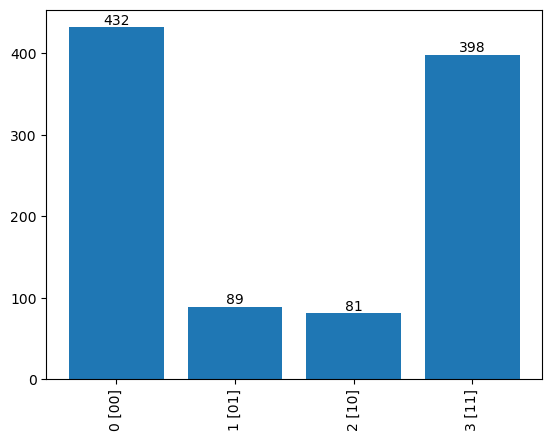

[432, 89, 81, 398]

In [8]:
print("READ OUT STATE VECTOR: ")
print(job.get_svec())
print("READ OUT CREGISTER: ", end="")
print( job.get_creg()[0])
job.plot_counts()

# More on NoiseProfile

## the `NoiseProfile` class
`NoiseProfile` has the following fields
* `noise_chan_init` - can be `NoiseChannel` or `NoiseChannelSequence` or `None` (default)
* `noise_chan_allgates` - can be `NoiseChannel` or `NoiseChannelSequence` or `None` (default)
* `noise_chan_qubits` - can be `NoiseChannelApplierSequense` or `None` (default)
* `noise_chan_allsteps` - can be `NoiseChannelApplierSequense` or `None` (default)

First, about `NoiseChannel`, `NoiseChannelSequence`, `NoiseChannelApplierSequence`
* `NoiseChannel` - is a representation of a noise channel in form of *kraus map*. Includes three fields
    * a sequence of $(k_i,p_i)$, to enable computing of $\sum_{i=1}^m(p_i k_i \rho k_i^\dagger)$, where $K_1,K_2,...K_m$ are kraus operators.
    * `name` for that channel (e.g., 'PF(0.10)' for noise channel bit-flip with $p_i = 0.1$).
    * `nqubits` the number of qubits this channel acts on.
* `NoiseChannelSequence` - if a sequence of `NoiseChannel`s are to be applied together, `NoiseChannelSequence` is used. It simply stores a sequence of `NoiseChannel`s. It also has a `name` field to represent the list of `NoiseChannel`s (e.g., 'PF(0.10),BF(0.05)')
* `NoiseChannelApplierSequence` - specification of applying a noise channel on certain qubits is refered to as `applier`. E.g., `(BF(0.05), [0,1,2])` specifies applyting bit-flip with probability of 0.05 to qubits 0, 1 and 2. Again, in general there can be a need to have a sequence of `appliers`, hence we have `KrausOperatorApplierSequence`. As  common theme, this also has a `name` field for the entire applier sequence.

Now, back to `NoiseProfile`.
* `noise_chan_init` specifies a `NoiseChannel`, or a `NoiseChannelSequence` to be applied to *all* qubits at the initialization of the quantum computer. The noise channels specified in this *must* be 1-qubit.
* `noise_chan_allgates` specifies a `NoiseChannel`, or a `NoiseChannelSequence` to be applied after *each* gate in the circuit to the target qubits of the gate. The noise channels specified in this *must* be 1-qubit.
* `noise_chan_qubits` specifies a `NoiseChannelApplierSequence` to be applied after *each* gate in the circuit. The qubits to which the noise channel is actually applied is the intersection of the set of qubits that gate is applied to and the qubits in individual applier entries. The noise channels specified in this *must* be 1-qubit.
* `noise_chan_allsteps` - specifies a `NoiseChannelApplierSequense` to be applied after each step in the circuit to the specified qubits. The noise channels specified in this *must* be 1-qubit, or *must* match the size of the qubits in the 'applier'.

## 1-qubit, 2-qubit (and potentially, multi-qubit) noise channels
Noise channels can be 1-qubit, 2-qubit, or in general, multi-qubit in size. The size of the noise channel is checked at the time of applying the channel -
* if the noise channel is 1-qubit sized, it gets *broadcast* to all the qubits it is applied to. That is, it is individually applied to each of the qubits in the applier.
* if not 1-qubit, then the size of the noise channel *must* match the number of qubits, else an exception is raised.

# Applying a more general NoiseProfile to the circuit
## init, qubits, and allgates components of NoiseModel

Draw the circuit before applying the noise profile

q000 -[H]-[.]-[M]-
           |   |  
q001 -----[X]-[M]-
               |  
creg ==========v==
                  

And, now draw the circuit *after* applying the noise profile

q000 -[INIT:GAD(0.10,0.05)]-[H]-[H:PD(0.10)]-[H:BF(0.10)]-[.]-[CX:PD(0.10)]-[CX:BF(0.10)]-[M]-
                                                           |                               |  
q001 -[INIT:GAD(0.10,0.05)]-------------------------------[X]---------------[CX:BF(0.10)]-[M]-
                                                                                           |  
creg ======================================================================================v==
                                                                                              


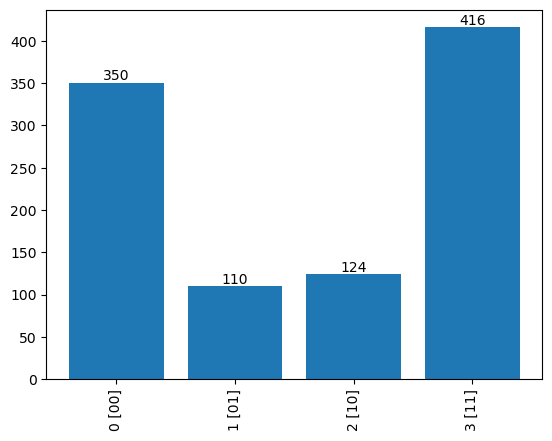

[350, 110, 124, 416]

In [9]:
# start with the same simple circuit
bellckt = qckt.QCkt(2, 2)
bellckt.H(0)
bellckt.CX(0,1)
bellckt.M([0,1],[0,1])
print('Draw the circuit before applying the noise profile\n')
bellckt.draw()
print()

noise_profile = ns.NoiseProfile(
    noise_chan_init=ns.generalized_amplitude_damping(probability=0.1,gamma=0.05),
    noise_chan_allgates=ns.bit_flip(0.1),
    noise_chan_qubits=ns.NoiseChannelApplierSequense(ns.phase_damping(gamma=0.1),[0]),
    )
bellckt.set_noise_profile(noise_profile=noise_profile)
print('And, now draw the circuit *after* applying the noise profile\n')
bellckt.draw()


job = qckt.Job(bellckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

## allsteps component of NoiseModel
To avoid too many noise elements, we try out using the 'allsteps' noise profile separately here.

And, lets use `NoiseChannelSequence` for it.

Draw the circuit before applying the noise profile

q000 -[H]-[.]-[M]-
           |   |  
q001 -----[X]-[M]-
               |  
creg ==========v==
                  

And, now draw the circuit *after* applying the noise profile

q000 -[H]-----------------------------[.]-----------------------------[M]-
                                       |                               |  
q001 -----[AS:BF(0.10)]-[AS:PF(0.10)]-[X]-[AS:BF(0.10)]-[AS:PF(0.10)]-[M]-
                                                                       |  
creg ==================================================================v==
                                                                          


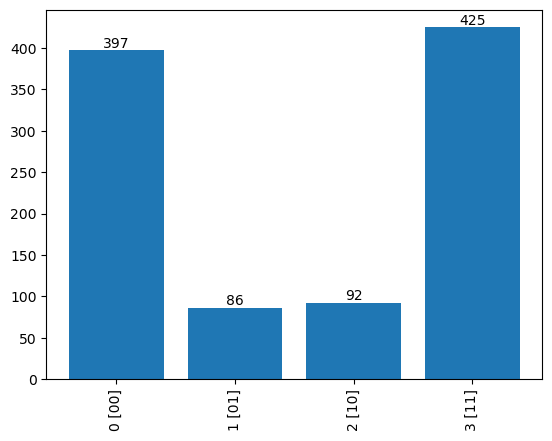

[397, 86, 92, 425]

In [10]:
# start with the same simple circuit
bellckt = qckt.QCkt(2, 2)
bellckt.H(0)
bellckt.CX(0,1)
bellckt.M([0,1],[0,1])
print('Draw the circuit before applying the noise profile\n')
bellckt.draw()
print()

noise_profile = ns.NoiseProfile(
    noise_chan_allsteps=ns.NoiseChannelApplierSequense(
        noise_chan=ns.NoiseChannelSequence(
            ns.bit_flip(0.1),
            ns.phase_flip(0.1),
            ),
        qubit_list=[1]
        )
    )
bellckt.set_noise_profile(noise_profile=noise_profile)
print('And, now draw the circuit *after* applying the noise profile\n')
bellckt.draw()


job = qckt.Job(bellckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

## apply noise to all the gates of a type
In  addition to `NoiseProfile`, another way to apply noise globally is to specify noise for individual gate types using `.set_noise_on_all()`.

**Note: Global Noise speccification applies to the entire circuit**. As you will notice, the global noise specifications, `NoiseProfile` as well as `.set_noise_on_all()`, are applied to the entire circuit irrespective of whether they are specified -- at the beginning, middle, or end of the circuit definition.

**Note: 2-qubit and multi-qubit noise channels can be specified here**. If number of qubits match, the noise channel(s) given in `noise_chan` can be 2-qubit or mult-quibit kraus operators.

q000 -[H]-[H:BF(0.15)]-[.]------------------[M]-
                        |                    |  
q001 ------------------[X]-[H]-[H:BF(0.15)]-[M]-
                                             |  
creg ========================================v==
                                                


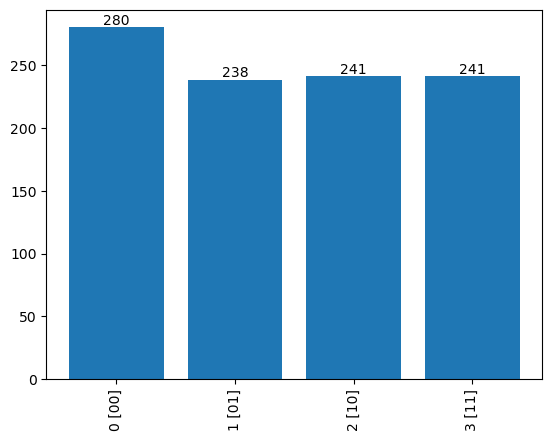

[280, 238, 241, 241]

In [11]:
# same simple circuit, added another H(1) at the end just to illustrate the `.add_noise_to_all()` functionality
bellckt = qckt.QCkt(2, 2)
bellckt.H(0)
bellckt.CX(0,1)
bellckt.H(1)
bellckt.M([0,1],[0,1])

# apply noise to all H gates
bellckt.H.set_noise_on_all(noise_chan=ns.bit_flip(0.15))
bellckt.draw()

job = qckt.Job(bellckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

## nothing different with user defined gates

q000 -[myH M]-[myH:BF(0.15)]-[.]------------------------[M]-
                              |                          |  
q001 ------------------------[X]-[myH M]-[myH:BF(0.15)]-[M]-
                                                         |  
creg ====================================================v==
                                                            


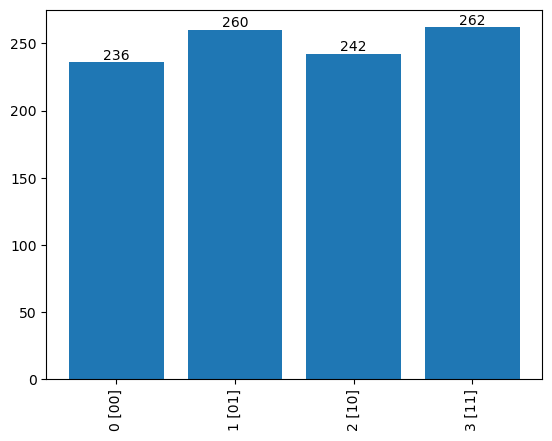

[236, 260, 242, 262]

In [12]:
sqr2 = np.sqrt(2)
qckt.define_gate('myH', np.matrix([[1/sqr2,1/sqr2],[1/sqr2,-1/sqr2]],dtype=complex))
# same simple circuit
bellckt = qckt.QCkt(2, 2)
bellckt.myH(0)
bellckt.CX(0,1)
bellckt.myH(1)
bellckt.M([0,1],[0,1])

# apply noise to all myH gates
bellckt.myH.set_noise_on_all(noise_chan=ns.bit_flip(0.15))
bellckt.draw()

job = qckt.Job(bellckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

# Adding noise to circuit diretly as opposed to overlaying global noise profile on a circuit
While overlaying global noise profile (NoiseProfile, and circuit.GATE.set_noise_on_all()) is expected to be more convinient, adding noise while building the circuit is also supported.
* `circuit.NOISE(noise_chan, qubits_list)` - this adds noise at a step in the circuit. `noise_chan` can be `NoiseChannel` or `NoiseChannelSequence`, and `qubits_list` is a list of qubits on which to apply this noise.
* `circuit.GATE(qubits).add_noise(noise_chan)` - this adds noise to the specific `GATE` instance. Of course, `GATE` would be any built-in or user defined gate. `noise_chan` can be `NoiseChannel` or `NoiseChannelSequence`, and that noise is applied to the qubits of this gate instance.

**Note: 2-qubit and multi-qubit noise channels can be specified here**. If number of qubits match, the noise channel(s) given in `noise_chan` can be 2-qubit or mult-quibit noise channels in each of the above.

As you can see, the noise gets *hardcoded* in the circuit using these, however, might be useful in specific situations.

q000 -[H]-[NS:BF(0.15)]-[.]------------------[M]-
                         |                    |  
q001 -------------------[X]-[H]-[H:BF(0.15)]-[M]-
                                              |  
creg =========================================v==
                                                 


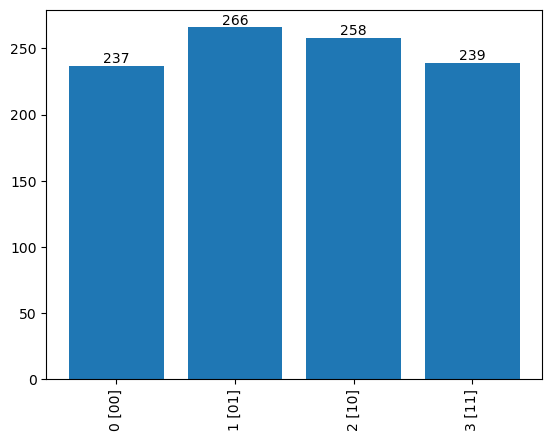

[237, 266, 258, 239]

In [13]:
# same simple circuit - with noise directly added; added to give the same effect as in the circuit above
bellckt = qckt.QCkt(2, 2)
bellckt.H(0)
bellckt.NOISE(ns.bit_flip(0.15),[0])
bellckt.CX(0,1)
bellckt.H(1).set_noise(ns.bit_flip(0.15))
bellckt.M([0,1],[0,1])
bellckt.draw()

job = qckt.Job(bellckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

# 2-qubit noise channels


## adding 2-qubit noise to using `.set_noise_on_all()`

q000 -[H]-[.]-----[M]-
           |       |  
q001 -----[X]-[.]-[M]-
               |   |  
q002 ---------[X]-[M]-
                   |  
creg ==============v==
                      

q000 -[H]-[.]-[CX:2DEP(0.1)]--------------------[M]-
           |                                     |  
q001 -----[X]-[CX:2DEP(0.1)]-[.]-[CX:2DEP(0.1)]-[M]-
                              |                  |  
q002 ------------------------[X]-[CX:2DEP(0.1)]-[M]-
                                                 |  
creg ============================================v==
                                                    


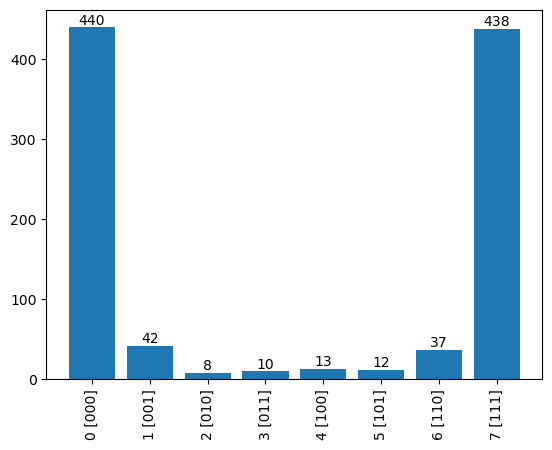

[440, 42, 8, 10, 13, 12, 37, 438]

In [14]:
# start with a ghz circuit
ghzckt = qckt.QCkt(3, 3)
ghzckt.H(0)
ghzckt.CX(0,1)
ghzckt.CX(1,2)
ghzckt.M([0,1,2],[0,1,2])
ghzckt.draw()
print()

ghzckt.CX.set_noise_on_all(noise_chan=ns.two_qubit_depolarizing(probability=0.1))
ghzckt.draw()

job = qckt.Job(ghzckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

## adding 2-qubit noise directly to a gate instance

q000 -[H]-[.]-[CX:2DEP(0.1)]--------------------[M]-
           |                                     |  
q001 -----[X]-[CX:2DEP(0.1)]-[.]-[CX:2DEP(0.1)]-[M]-
                              |                  |  
q002 ------------------------[X]-[CX:2DEP(0.1)]-[M]-
                                                 |  
creg ============================================v==
                                                    


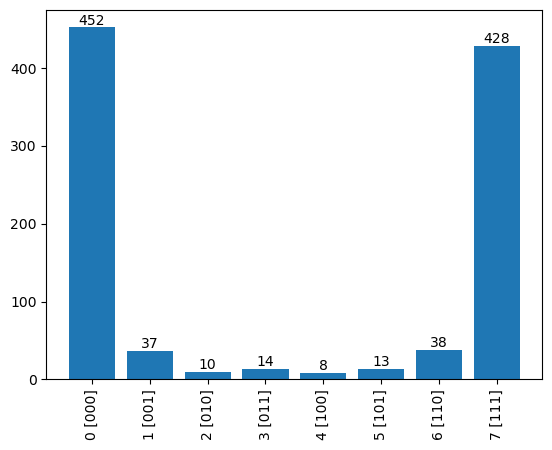

[452, 37, 10, 14, 8, 13, 38, 428]

In [15]:
# start with the same ghz circuit
ghzckt = qckt.QCkt(3, 3)
ghzckt.H(0)
ghzckt.CX(0,1).set_noise(ns.two_qubit_depolarizing(probability=0.1))
ghzckt.CX(1,2).set_noise(ns.two_qubit_depolarizing(probability=0.1))
ghzckt.M([0,1,2],[0,1,2])
ghzckt.draw()

job = qckt.Job(ghzckt, shots=1000)
bk = qsimSvc().getInstance('dmqsim-eng')
bk.runjob(job)
job.plot_counts()

# Custom noise channels
You can define a custom noise channel as shown below.

**Note**: the operators `X` and `I` used below are defined as regular qucircuit gates, i.e., a list with two elements - `[name, numpy.matrix([...], dtype=complex)]`. Where `name` is a string name for this operator, and the seond element is a unitary matrix as a `numpy.matrix()`

In [16]:
def my_bit_flip(probability=0.05):
    I = ['I',np.matrix([[1.0,0.0],[0.0,1.0]],dtype=complex)]
    X = ['X', np.matrix([[0,1],[1,0]],dtype=complex)]

    noise_channel = ns.NoiseChannel(
        name=f'myBF({probability:.2f})',
        noise_chan=[(X,probability),(I,(1-probability))],
        nqubits=1,
        )
    return noise_channel

bellckt = qckt.QCkt(2, 2)
bellckt.H(0)
bellckt.CX(0,1)
bellckt.M([0,1],[0,1])

noise_profile = ns.NoiseProfile(noise_chan_allgates=my_bit_flip(0.1))
bellckt.set_noise_profile(noise_profile=noise_profile)
bellckt.draw()

q000 -[H]-[H:myBF(0.10)]-[.]-[CX:myBF(0.10)]-[M]-
                          |                   |  
q001 --------------------[X]-[CX:myBF(0.10)]-[M]-
                                              |  
creg =========================================v==
                                                 
